# AI-Generated Image Detection

In [1]:
!pip install ImageHash==4.3.1

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
import seaborn as sns

import pathlib
from zipfile import ZipFile
import imagehash
import random

### 1.   Importing the Data

- Since the data is in a zip file, It needs to be unzipped to access the images

In [3]:
# Unzip folder
zip_object = ZipFile('datasets/dataset2.zip', 'r')
zip_object.extractall()

-   The data come by default with a training and testing already established

In [4]:
# Storing image data into variables
train_dir = pathlib.Path('train/').with_suffix('')
test_dir = pathlib.Path('test/').with_suffix('')

In [5]:
train_img_array, test_img_array = list(train_dir.glob('*/*')), list(test_dir.glob('*/*'))
total_dataset = train_img_array + test_img_array

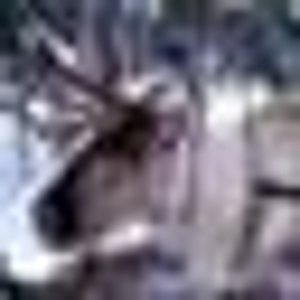

In [6]:
# Display random image in the dataset
random_number = random.randint(0, len(train_img_array))
Image.open(str(train_img_array[random_number])).resize((300, 300))

#### Information about the dataset

In [7]:
# Check the number of items in the dataset
print(f"Training image count : {len(train_img_array)} \nTesting image count : {len(test_img_array)} \nTotal data : {len(total_dataset)}")

Training image count : 100000 
Testing image count : 20000 
Total data : 120000


- The current dataset is quite large, and using dataset in its entirety may be problematic due to computational limitations especially when dealing with images. We need a way to reduce the amount of data in the dataset.

In [8]:
# Function to take a percentage of the items into a list
def reduce_list(list1: list, percentage: float):
  list2 = []
  for item in list1:

    r = random.random()
    if r < percentage:
      list2.append(item)
  return list2

total_dataset = reduce_list(total_dataset, 0.3) #Takes 30% of the dataset

In [9]:
# Check the number of items in the dataset
print(f"Total data : {len(total_dataset)}")

Total data : 36104


In [10]:
# Check the number of type image extension in the dataset
image_types = [
    {"file_type": "jpeg", "count": 0},
    {"file_type": "png", "count": 0},
    {"file_type": "jpg", "count": 0},
    {"file_type": "other", "count": 0},
]

def count_filetype(dataset, type_array):
    type_count = len(type_array)
    for c, file_name in enumerate(dataset):
        # Split the file name by the period (.) character
        parts = str(file_name).split(".")
        file_extension = str(parts[-1]).lower() # Get the extension type.
        for counter in range(type_count):
            if file_extension == type_array[counter]["file_type"]:
                type_array[counter]["count"]+=1
                break
            if counter == (type_count - 1): # If the loop falls in the "other category"
                type_array[-1]["count"]+=1


# Counts image types occurrence for dataset 
count_filetype(total_dataset, image_types)

# Display result for train dataset
for image_type in image_types:
  print(f"Number of {image_type['file_type']} images inside the dataset : {image_type['count']}")

Number of jpeg images inside the dataset : 0
Number of png images inside the dataset : 0
Number of jpg images inside the dataset : 36104
Number of other images inside the dataset : 0


- We can observe that the dataset only contains jpg images in both the training and testing dataset

### 2.  Data cleaning

#### Check if the dataset contains corrupted and duplicated images.

In [11]:
def clean_image_data(dataset: list):
    cleaned_images = 0
    corrupted_images = 0
    imgs_shape = []  
    hash_dict = {}
    duplicate_images = 0  
    temp_dataset: list[bool] = [] 

    for count, filename in enumerate(dataset):
        filename = str(filename)
        try:
            with Image.open(filename) as img:
                # Calculate the hash of the image
                img_hash = imagehash.average_hash(img)

                # Check if the hash already exists in the dictionary
                if img_hash in hash_dict:
                    duplicate_images+=1
                    temp_dataset.append(True)
                else:
                    hash_dict[img_hash] = filename
                    temp_dataset.append(False)
                    
                imgs_shape.append(img.size)
                cleaned_images+=1

        except Exception as e:
            corrupted_images+=1
            print(f"Corrupted image: {filename}, Error: {e}")

    return cleaned_images, corrupted_images, duplicate_images, temp_dataset, imgs_shape

cleaned_images, corrupted_images, duplicate_images, duplicates_values, imgs_shape = clean_image_data(total_dataset)

print(f"Cleaned images: {cleaned_images}")
print(f"Corrupted images: {corrupted_images}")
print("duplicate images : ", duplicate_images )

Cleaned images: 36104
Corrupted images: 0
duplicate images :  499


- We observe that the dataset does not contain any corrupted image
- However duplicates images are in the dataset.

- Duplicated images are based on the image content rather than filenames. 
- The process to find duplicated images is as follows:
    - Turn the image content into a hash value and get the average value of the hash.
    - Compare images hash value and determine if there are duplicate or near-duplicate images based on similarity thresholds.

In [12]:
# Transforming the dataset list into a pandas.Series Dataframe 
df = pd.DataFrame(total_dataset, columns=["Filename"])
shapes = pd.DataFrame(imgs_shape, columns=["width", "height"])
dupl = pd.DataFrame(duplicates_values, columns=["duplicated"])

df = df.merge(shapes, left_index=True, right_index=True)

In [13]:
# Remove duplicates
print("Before removing duplicates :", len(df))

df = df[~dupl["duplicated"]]

print("After removing duplicates :", len(df))

Before removing duplicates : 36104
After removing duplicates : 35605


In [14]:
# reset index num 
df.reset_index(drop=True)

,Filename,width,height
0,train/REAL/2864 (4).jpg,32,32
1,train/REAL/3536 (3).jpg,32,32
2,train/REAL/1130 (3).jpg,32,32
3,train/REAL/1705 (2).jpg,32,32
4,train/REAL/2764 (6).jpg,32,32
...,...,...,...
35600,test/FAKE/387 (8).jpg,32,32
35601,test/FAKE/641 (8).jpg,32,32
35602,test/FAKE/68 (10).jpg,32,32
35603,test/FAKE/234 (10).jpg,32,32


In [15]:
df.shape

(35605, 3)

In [16]:
# creating new columns to tag data inside the dataset
df["folder_type"] = df["Filename"].apply(lambda x: "Test" if str(x).split("/")[0] == "test" else "Train") 
df["tag"] = df["Filename"].apply(lambda x: "REAL" if str(x).split("/")[1] == "REAL" else "FAKE") 

In [17]:
df.head()

,Filename,width,height,folder_type,tag
0,train/REAL/2864 (4).jpg,32,32,Train,REAL
1,train/REAL/3536 (3).jpg,32,32,Train,REAL
2,train/REAL/1130 (3).jpg,32,32,Train,REAL
3,train/REAL/1705 (2).jpg,32,32,Train,REAL
4,train/REAL/2764 (6).jpg,32,32,Train,REAL


### 3.  Data exploration

In [18]:
# Displays metrics about numerical data
df.describe()

,width,height
count,35605.0,35605.0
mean,32.0,32.0
std,0.0,0.0
min,32.0,32.0
25%,32.0,32.0
50%,32.0,32.0
75%,32.0,32.0
max,32.0,32.0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35605 entries, 0 to 36103
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Filename     35605 non-null  object
 1   width        35605 non-null  int64 
 2   height       35605 non-null  int64 
 3   folder_type  35605 non-null  object
 4   tag          35605 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.6+ MB


In [188]:
df.shape

(35768, 5)

In [189]:
df.apply(pd.Series.unique)

Filename       [train/REAL/4053 (9).jpg, train/REAL/2864 (4)....
width                                                       [32]
height                                                      [32]
folder_type                                        [Train, Test]
tag                                                 [REAL, FAKE]
dtype: object

- From this data we observe that all the images in the dataset are in 32x32 pixels

In [190]:
# Displays metrics about non-numerical data
df.describe(include=['object'])

,Filename,folder_type,tag
count,35768,35768,35768
unique,35768,2,2
top,train/REAL/4053 (9).jpg,Train,FAKE
freq,1,29743,17934


In [191]:
# Get the number of "REAL" and "FAKE" tags
num_real_tags = df["tag"].apply(lambda x: x.count("REAL")).sum()
num_fake_tags = df["tag"].apply(lambda x: x.count("FAKE")).sum()

num_train_real = df[df["folder_type"] == "Train"]["tag"].apply(lambda x: x.count("REAL")).sum()
num_train_fake = df[df["folder_type"] == "Train"]["tag"].apply(lambda x: x.count("FAKE")).sum()

num_test_real = df[df["folder_type"] == "Test"]["tag"].apply(lambda x: x.count("REAL")).sum()
num_test_fake = df[df["folder_type"] == "Test"]["tag"].apply(lambda x: x.count("FAKE")).sum()

# Get the number of "Train" and "Test" type
num_train = df["folder_type"].apply(lambda x: x.count("Train")).sum()
num_test = df["folder_type"].apply(lambda x: x.count("Test")).sum()

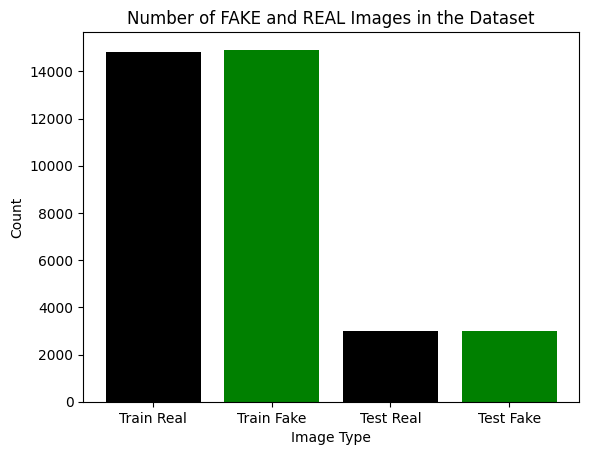

Number of 'FAKE' images: 17934
Number of 'REAL' images: 17834
Difference of -100 images


In [192]:
# Create a bar chart
plt.bar(['Train Real', 'Train Fake', "Test Real", "Test Fake"], [num_train_real, num_train_fake, num_test_real, num_test_fake], color=["black", "green"])
plt.xlabel('Image Type')
plt.ylabel('Count')
plt.title('Number of FAKE and REAL Images in the Dataset')
plt.show()
print("Number of 'FAKE' images:", num_fake_tags)
print("Number of 'REAL' images:", num_real_tags)
print("Difference of", num_real_tags - num_fake_tags, "images")

-   from this chart it is noticeable that the difference between REAL and FAKE images is not much

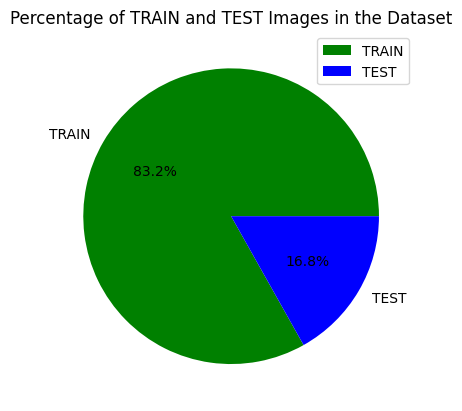

Number of 'Train' images: 29743
Number of 'Test' images: 6025


In [193]:
# Create a piechart

plt.pie([num_train, num_test], labels=["TRAIN", "TEST"], colors=["green", "blue"], autopct='%1.1f%%')
plt.title('Percentage of TRAIN and TEST Images in the Dataset')
plt.legend()
plt.show()
print("Number of 'Train' images:", num_train)
print("Number of 'Test' images:", num_test)

- From this chart, we observe that the distribution of the train and test split is not proportional. Ii might be necessary re-split the dataset in order to redistribute it proportionally. For example, splitting it in a 80:20 ratio.  

### 4. Data preprocessing

In [194]:
df.head()

,Filename,width,height,folder_type,tag
0,train/REAL/4053 (9).jpg,32,32,Train,REAL
1,train/REAL/2864 (4).jpg,32,32,Train,REAL
2,train/REAL/3536 (3).jpg,32,32,Train,REAL
3,train/REAL/3691 (6).jpg,32,32,Train,REAL
4,train/REAL/2764 (6).jpg,32,32,Train,REAL


In [195]:
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.decomposition import PCA

from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

In [196]:
# Function preprocess image
def preprocess_image(image_path, target_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image

In [197]:
img_height = 32
img_width = 32
BATCH_SIZE = 32

In [198]:
image_paths = df["Filename"].copy().astype(str).tolist()
labels = df["tag"].copy().astype(str).tolist()

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [199]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_test = le.fit_transform(Y_test)
class_names = le.classes_

class_names

array(['FAKE', 'REAL'], dtype='<U4')

In [200]:
le.transform(['FAKE', 'REAL'])

array([0, 1])

Label encoded
- FAKE => 0
- REAL => 1

In [201]:
# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

# Map preprocessing function to the datasets
train_dataset = train_ds.cache().map(lambda x, y: (preprocess_image(x, target_size=(img_height, img_width)), y))
test_dataset = test_ds.cache().map(lambda x, y: (preprocess_image(x, target_size=(img_height, img_width)), y))

# shuffle and batch the datasets
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [202]:
# Iterate over the dataset (for demonstration)
for batch_images, batch_labels in train_dataset.take(1):
    numpy_array = batch_labels.numpy()
    print("Batch images shape:", batch_images.shape)
    print("length:", len(numpy_array))
    print("Fake num:", np.count_nonzero(numpy_array == 0))
    print("Real num:", np.count_nonzero(numpy_array == 1))
    # print(numpy_array)

Batch images shape: (32, 32, 32, 3)
length: 32
Fake num: 16
Real num: 16


In [203]:
# Checking that if pixels have been normalized as intended
for batch_images, batch_labels in train_dataset.take(1):
    print(f"Least value : {np.min(batch_images[0])}\nHighest value {np.max(batch_images[0])}")

Least value : 0.0
Highest value 1.0


- Checking if the images can still be visualised

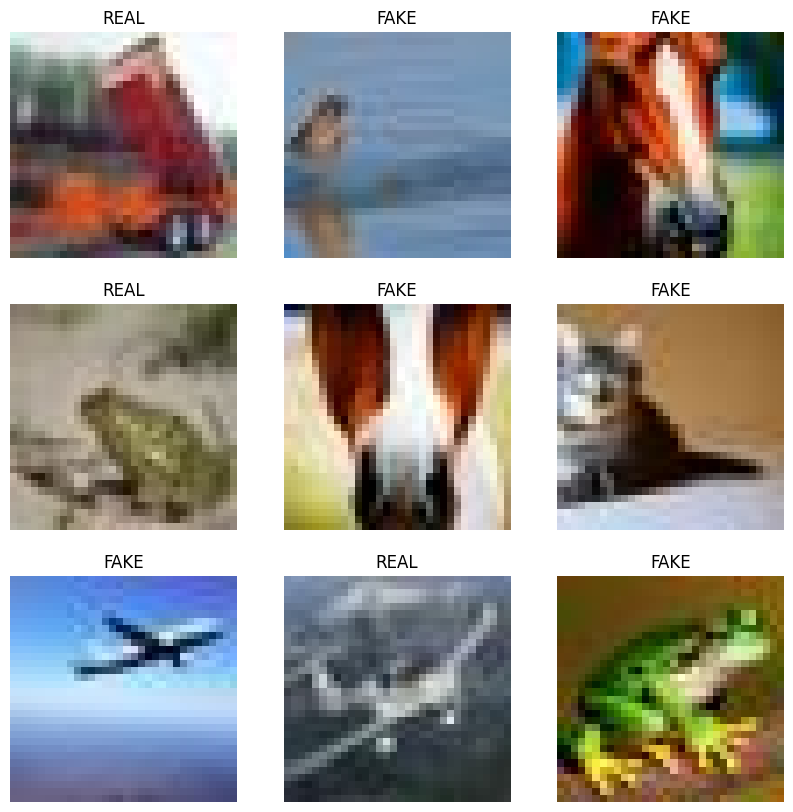

In [204]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.reshape(images[i], (img_height,img_width,3)))
    plt.title(
      class_names[labels[i]]
    )
    plt.axis("off")

In [205]:
# Reshape dataset features to 2D matrix
temp_x_train = []
train_labels_list = []
for batch_images, batch_labels in train_dataset:
    features = batch_images
    features = np.reshape(features, (features.shape[0], -1))
    temp_x_train.extend(features)
    train_labels_list.extend(batch_labels.numpy())

temp_x_test = []
test_labels_list = []
for batch_images, batch_labels in test_dataset:
    features = batch_images
    features = np.reshape(features, (features.shape[0], -1))
    temp_x_test.extend(features)
    test_labels_list.extend(batch_labels.numpy())

# Convert lists to arrays
Xr_train = np.array(temp_x_train)
Yr_train = np.array(train_labels_list)
Xr_test = np.array(temp_x_test)
Yr_test = np.array(test_labels_list)

In [206]:
Xr_train.shape

(28614, 3072)

In [207]:
Xr_test.shape

(7154, 3072)

In [208]:
# Using PCA to transform the dataset features. PCA will retain 99% of the variance in the original data.
pca = PCA(n_components=0.99)
pcaX_train = pca.fit_transform(Xr_train)

In [209]:
pcaX_train.shape

(28614, 618)

- The code above is using PCA to reduce the number of features in the dataset to 99% of the original variance. This means that the dataset will have fewer features than the original dataset, but it will still contain most of the image important information.

In [210]:
# Reconstructing the images using pca inverse
X_reconstruct = pca.inverse_transform(pcaX_train)

#Recontructed training set dims
X_reconstruct.shape

(28614, 3072)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


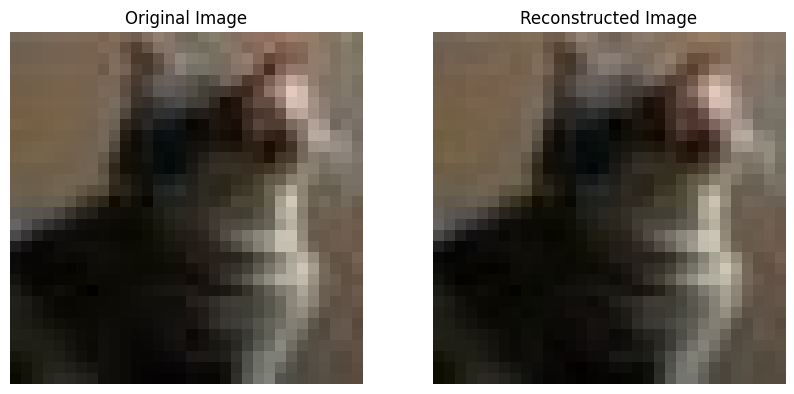

In [211]:
#Visualizing a sample reconstructed image
plt.figure(figsize=(10,5))
index = np.random.randint(X_reconstruct.shape[0])
plt.subplot(121)
plt.title("Original Image")
plt.imshow(np.reshape(Xr_train[index], (img_height,img_width,3)))
plt.axis('off')
plt.subplot(122)
plt.title("Reconstructed Image")
plt.imshow((np.reshape(X_reconstruct[index],(img_height, img_width,3))))
plt.axis('off')
plt.show()

- The visibility of the image was not significantly affected by reducing features with PCA, as we observed.

### 5. Modeling

##### Training model using Classifier ML algorithms

In [212]:
import warnings

warnings.filterwarnings('ignore')

In [213]:
models = {}

models['SVC'] = LinearSVC(verbose=0, max_iter=500)
models['SGD'] = SGDClassifier()

In [214]:
performance_results = []

In [215]:
# use crossvalidate to on all the models to get the accuracy and f1-score
for name, model in models.items():
    scores = cross_validate(model, pcaX_train, Yr_train, cv=5, scoring=['accuracy', 'f1'], return_train_score=True)
    performance_results.append({
        "name": name, 
        "perf_train": scores['train_accuracy'].mean(), 
        "perf_test": scores['test_accuracy'].mean()
        })
    print(f"Model : {name}")
    print("Accuracy:" , 'train:', scores['train_accuracy'].mean(), '| test:', scores['test_accuracy'].mean())
    print("F1-score:" , 'train:', scores['train_f1'].mean(), '| test: ', scores['test_f1'].mean())
    print("-----------------------------------------------------------")

Model : SVC
Accuracy: train: 0.6567152299832877 | test: 0.6345844502547805
F1-score: train: 0.6529139915221089 | test:  0.6318584022630602
-----------------------------------------------------------
Model : SGD
Accuracy: train: 0.659257760491983 | test: 0.6299712285147534
F1-score: train: 0.6521786261375226 | test:  0.6236525005199993
-----------------------------------------------------------


##### Training model using a deep learning approach

- Building a Convolutional Neural Networks (CNNs)

In [216]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [217]:
AUTOTUNE = tf.data.AUTOTUNE

train_ann = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_ann = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [218]:
for image_batch, labels_batch in test_ann.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 32, 32, 3)
(32,)


In [219]:

num_classes = len(le.classes_)

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu', 
                input_shape=(img_height, img_width, 3)
                ),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes),
])

In [220]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [221]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 4, 4, 64)        

In [222]:
epochs=10
history = model.fit(
  train_ann,
  validation_data=test_ann,
  epochs=epochs,
  verbose=1
)

Epoch 1/10
895/895 [==============================] - 4s 4ms/step - loss: 0.3854 - accuracy: 0.8246 - val_loss: 0.2784 - val_accuracy: 0.8883
Epoch 2/10
895/895 [==============================] - 3s 3ms/step - loss: 0.2447 - accuracy: 0.9003 - val_loss: 0.2657 - val_accuracy: 0.8894
Epoch 3/10
895/895 [==============================] - 3s 3ms/step - loss: 0.2078 - accuracy: 0.9158 - val_loss: 0.2012 - val_accuracy: 0.9220
Epoch 4/10
895/895 [==============================] - 3s 3ms/step - loss: 0.1839 - accuracy: 0.9276 - val_loss: 0.2262 - val_accuracy: 0.9084
Epoch 5/10
895/895 [==============================] - 3s 3ms/step - loss: 0.1641 - accuracy: 0.9353 - val_loss: 0.1960 - val_accuracy: 0.9248
Epoch 6/10
895/895 [==============================] - 3s 3ms/step - loss: 0.1516 - accuracy: 0.9400 - val_loss: 0.1851 - val_accuracy: 0.9268
Epoch 7/10
895/895 [==============================] - 3s 3ms/step - loss: 0.1295 - accuracy: 0.9507 - val_loss: 0.1995 - val_accuracy: 0.9233
Epoch 

In [223]:
cnn_train_val, cnn_test_val = model.evaluate(train_ann)[1], model.evaluate(test_ann)[1]

# Add performance inside variable
performance_results.append({"name": "CNN", "perf_train": cnn_train_val, "perf_test": cnn_test_val})

224/224 [==============================] - 0s 947us/step - loss: 0.2048 - accuracy: 0.9269


### 7. Comparing performances

In [224]:
# Performance Comparison 
valid_accuracy = [x["perf_train"] for x in performance_results]
test_accuracy = [x["perf_test"] for x in performance_results]
index = [x["name"] for x in performance_results]

# print(value["name"])
accuracy_df = pd.DataFrame({'Train Accuracy':valid_accuracy,'Test Accuracy':test_accuracy},index=index)
accuracy_df

,Train Accuracy,Test Accuracy
SVC,0.656715,0.634584
SGD,0.659258,0.629971
CNN,0.975222,0.926894


<Axes: title={'center': 'Performance Comparison'}>

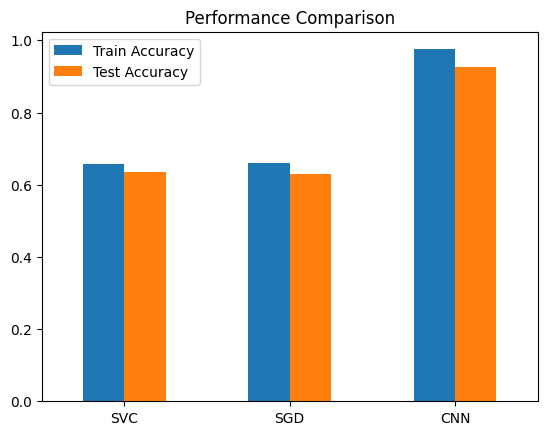

In [225]:
accuracy_df.plot.bar(rot=0, title = 'Performance Comparison')

- The model that has the best performance overall is CNN

- It seems that the model is overfitting to the training dataset since the accuracy result on the training is not the same testing set one.

### 8. Data augmentation

- To solve overfitting we will apply 
    - Data augmentation
    - Dropout
    - EarlyStopping

In [226]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
  ]
)

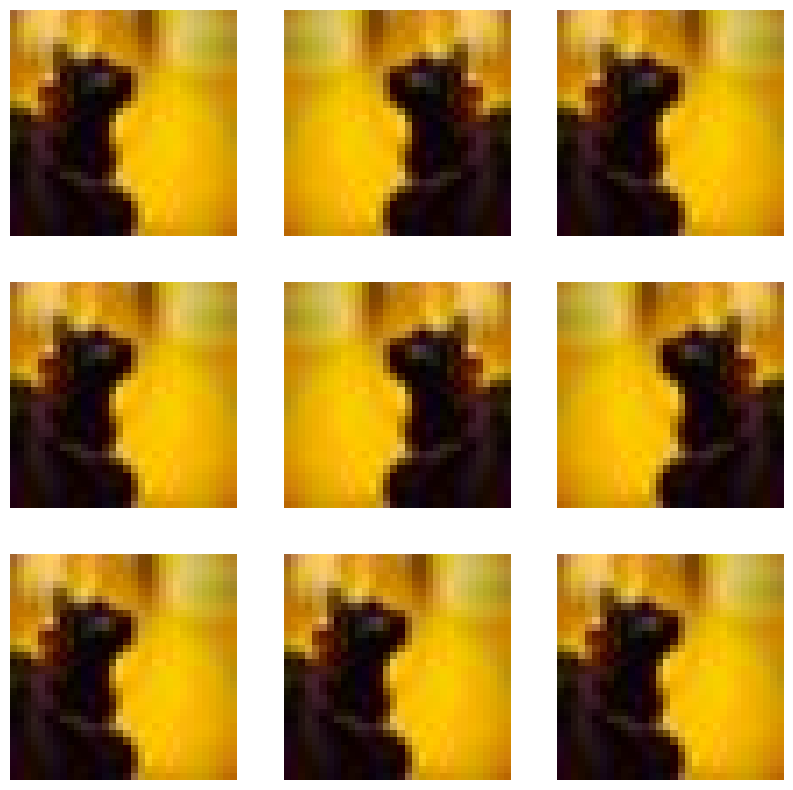

In [227]:
# Visualise the effect of the data visualisation
plt.figure(figsize=(10, 10))
for images, _ in train_ann.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((np.reshape(augmented_images[0],(img_height, img_width,3))))
    plt.axis("off")
  break

In [228]:
model_augmentation = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Dropout(0.5),
  
  layers.Flatten(),
  
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [229]:
model_augmentation.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [230]:
model_augmentation.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 64)         

In [231]:
epochs = 15

# Helps monitor the validation loss and stops training when it starts to increase
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

history_augmentation = model_augmentation.fit(
  train_ann,
  validation_data=test_ann,
  epochs=epochs,
  callbacks = [early_stopping]
)

Epoch 1/15


2024-04-23 18:36:46.127195: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


895/895 [==============================] - 4s 4ms/step - loss: 0.3996 - accuracy: 0.8144 - val_loss: 0.3601 - val_accuracy: 0.8372
Epoch 2/15
895/895 [==============================] - 3s 3ms/step - loss: 0.2765 - accuracy: 0.8869 - val_loss: 0.2691 - val_accuracy: 0.8912
Epoch 3/15
895/895 [==============================] - 3s 3ms/step - loss: 0.2475 - accuracy: 0.8981 - val_loss: 0.2342 - val_accuracy: 0.9047
Epoch 4/15
895/895 [==============================] - 3s 3ms/step - loss: 0.2280 - accuracy: 0.9084 - val_loss: 0.1953 - val_accuracy: 0.9238
Epoch 5/15
895/895 [==============================] - 3s 3ms/step - loss: 0.2086 - accuracy: 0.9161 - val_loss: 0.2078 - val_accuracy: 0.9150
Epoch 6/15
895/895 [==============================] - 3s 3ms/step - loss: 0.2020 - accuracy: 0.9192 - val_loss: 0.1894 - val_accuracy: 0.9205
Epoch 7/15
895/895 [==============================] - 3s 3ms/step - loss: 0.1913 - accuracy: 0.9225 - val_loss: 0.2257 - val_accuracy: 0.9111
Epoch 8/15
895/89

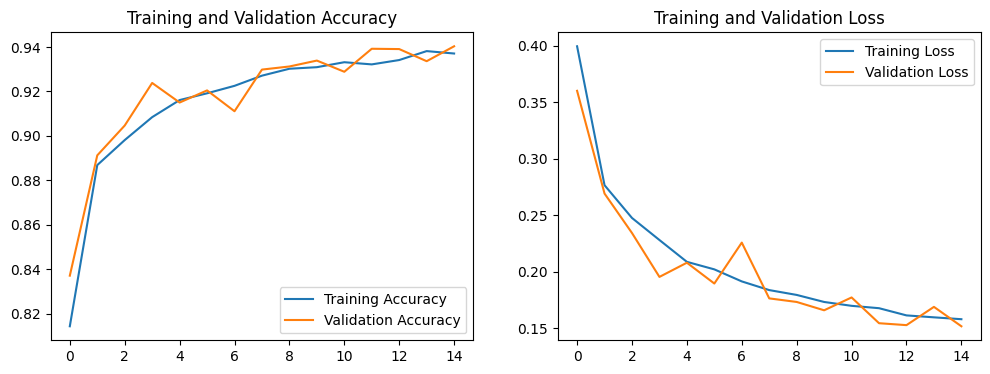

In [232]:
acc = history_augmentation.history['accuracy']
val_acc = history_augmentation.history['val_accuracy']

loss = history_augmentation.history['loss']
val_loss = history_augmentation.history['val_loss']

epochs_range = range(
    len(history_augmentation.history['accuracy'])
    )

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- As demonstrated with the graphs above, we can observe that the over-fitting issue that model had has drastically been reduced with the use of data augmentation 

### 9. Evaluating performance

In [233]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy

In [234]:
precision_acc = Precision()
recall_acc = Recall()
model_accuracy = Accuracy()

- Loading validation data from test datasets in order to evaluate performance of model

In [235]:
for batch in test_ann.take(1):
    X, y = batch
    y_predict = model_augmentation.predict(X)
    y_predict = y_predict.argmax(axis=1)
    precision_acc.update_state(y, y_predict)
    recall_acc.update_state(y, y_predict)
    model_accuracy.update_state(y, y_predict)

1/1 [==============================] - 0s 33ms/step


In [236]:
pd.DataFrame({'Performance':["{:0.2}".format(precision_acc.result().numpy()), "{:0.2}".format(recall_acc.result().numpy()), "{:0.2}".format(model_accuracy.result().numpy())]},index=["Precision", "Recall", "Accuracy"])

,Performance
Precision,1.0
Recall,0.85
Accuracy,0.91


In [237]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, y_predict)
cm

array([[12,  0],
       [ 3, 17]])

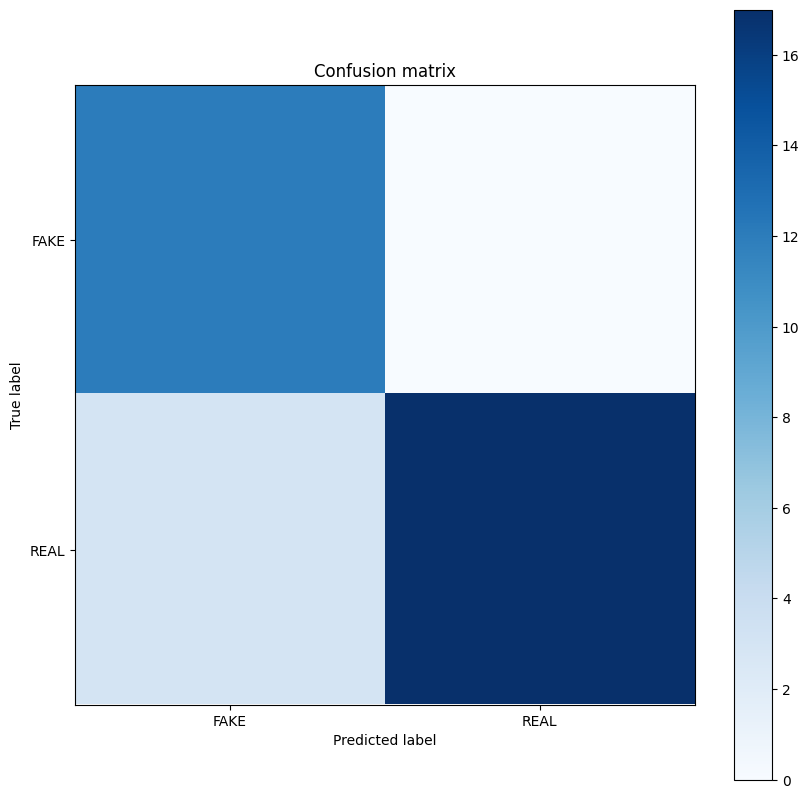

In [238]:
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(np.arange(len(class_names)), class_names)
plt.yticks(np.arange(len(class_names)), class_names)
plt.show()

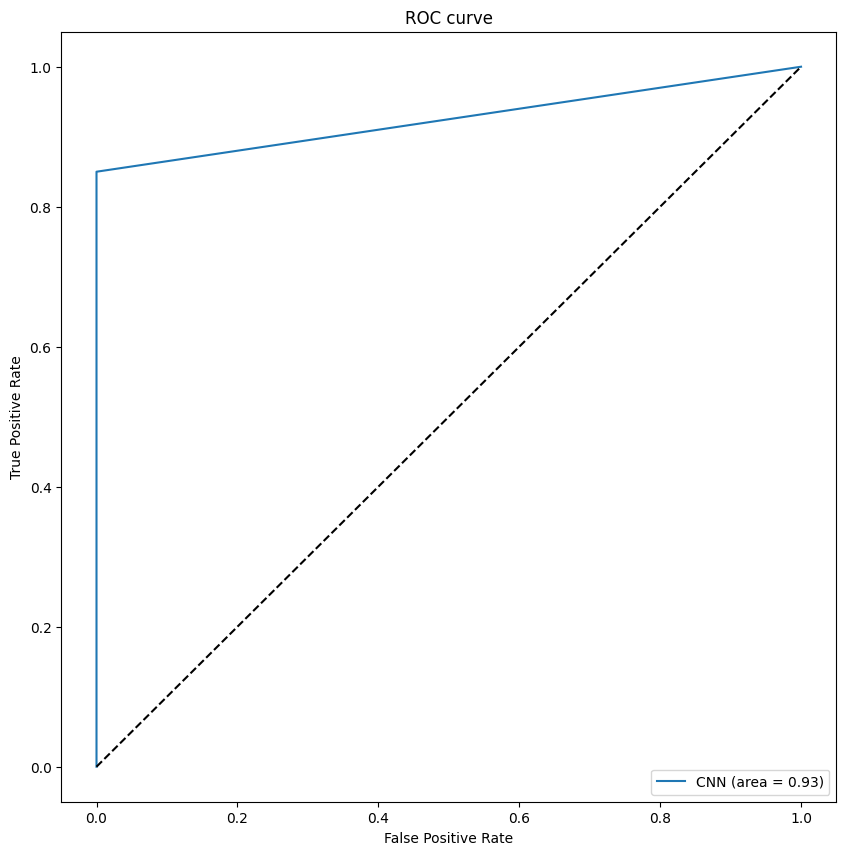

In [239]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y, y_predict)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label='CNN (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

### 10. Testing the model by predicting random images if it is real or ai-generated

1/1 [==============================] - 0s 34ms/step


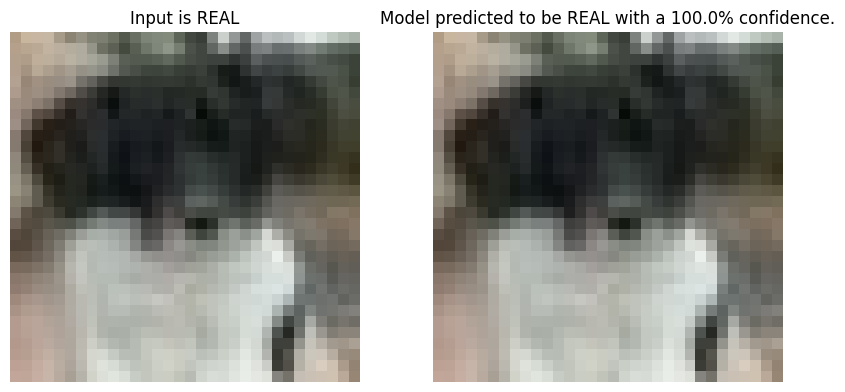

In [240]:
import re

def get_input_type(value: str) -> str:
    # print(value)
    pattern = r"REAL|FAKE"
    match = re.search(pattern, value)
    if match:
        return match.group()
    else:
        return None


random_index = np.random.randint(len(X_test) - 1)
test_input = X_test[random_index].replace(".jpg", "")

new_data = pathlib.Path(test_input).with_suffix('.jpg')
img = tf.keras.utils.load_img(
    new_data, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model_augmentation.predict(img_array)
score = tf.nn.softmax(predictions[0])


plt.figure(figsize=(10,10))
for i in range(2):
  ax = plt.subplot(2,2,1 + i)
  plt.imshow(np.reshape(img, (img_height,img_width,3)))
  plt.title(
      "Input is {}".format(get_input_type(test_input))
      if i == 0 else
      "Model predicted to be {} with a {:.1f}% confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
      )
  plt.axis("off")